### **Definir el directorio de trabajo con Google Colab**
Define el directorio de trabajo como la carpeta `working_directory` de la carpeta compartida `DS4A-Team12` de Drive.

In [ ]:
import os
from google.colab import drive 
# Enlazar a la carpeta data de la carpeta compartida en Drive
drive.mount('/content/drive')
working_dir = '/content/drive/MyDrive/DS4A-Team12/data'
os.chdir(working_dir)
!pwd

Mounted at /content/drive
/content/drive/My Drive/DS4A-Team12/data


In [ ]:
# Librerias relevantes
import time
import pandas as pd
import numpy as np
import json
import re
import joblib

### **Abrir base de datos de tomas nutricionales del ICBF (Dirección de Primera Infancia)**
Abre las primeras 98 columnas de todos los registros de la base de datos, preprocesados para asignarle a cada variable el tipo de dato correspondiente (archivo `TomasDPIpre.parquet` de 472.4 MB) como un dataframe de nombre `tom`.
Para preprocesar un archivo ir a [`Preprocesamiento_Tomas_.ipynb`](https://https://colab.research.google.com/drive/1ztyI5yfqs6LY7LOYXHr0q4WCrDdfotBs#scrollTo=KJM1uKZq71HA).

In [ ]:
time0 = time.time()
# Abre el diccionario con la estructura de datos definida para ambos datasets
#with open('datatypes_dictionaries/dtypes_vars_toma.json', 'r') as file:
 # dtypes_vars_toma = json.load(file)
#with open('datatypes_dictionaries/dtypes_sociodemo.json', 'r') as file:
 # dtypes_soc = json.load(file)
# Lee el archivo marcado
tom = pd.read_parquet('preprocessed_data/join_sociodemo_tomas_tagged.parquet')
#tom = tom.astype(dtypes_vars_toma)
tom.info()

geo = pd.read_csv('auxiliary_data/municipio_poblacion_sexo_edad_pib.csv')
geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206532 entries, 0 to 1206531
Data columns (total 71 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Cod_clase                  1206532 non-null  int64         
 1   Ind_grupo_sisben_4         1206532 non-null  category      
 2   Ind_nivel_sisben_4         1206532 non-null  int64         
 3   Tip_vivienda               1206532 non-null  int64         
 4   Ind_tiene_energia          1206532 non-null  int64         
 5   Ind_tiene_alcantarillado   1206532 non-null  int64         
 6   Ind_tiene_gas              1206532 non-null  int64         
 7   Ind_tiene_recoleccion      1206532 non-null  int64         
 8   Ind_tiene_acueducto        1206532 non-null  int64         
 9   n_hogares_vivienda         1206532 non-null  UInt8         
 10  Tip_ocupa_vivienda         1206532 non-null  int64         
 11  Ind_tiene_cocina           1206532 no

In [ ]:
tom.cod_mpio.nunique(), geo.DPMP.nunique()

(1050, 1122)

In [ ]:
geo.head()

,Unnamed: 0,DP,DPNOM,DPMP,MPIO,AÑO,Hombres_0,Hombres_1,Hombres_2,Hombres_3,Hombres_4,Hombres_5,Mujeres_0,Mujeres_1,Mujeres_2,Mujeres_3,Mujeres_4,Mujeres_5,Total Hombres,Total Mujeres,Total,PIB
0,0,5,Antioquia,5001,Medellín,2018,14474,14600,14699,14782,14861,14942,13828,13973,14097,14204,14309,14415,1140658,1286471,2427129,55082.301180
1,1,5,Antioquia,5001,Medellín,2019,14863,14902,14984,15040,15081,15122,14220,14244,14345,14428,14494,14559,1168926,1314619,2483545,59974.806184
2,2,5,Antioquia,5002,Abejorral,2018,132,130,129,132,136,141,136,132,132,134,135,137,10534,9833,20367,231.172055
3,3,5,Antioquia,5002,Abejorral,2019,130,128,129,131,134,139,131,130,130,131,132,135,10510,9748,20258,257.196344
4,4,5,Antioquia,5004,Abriaquí,2018,24,23,23,24,22,23,19,20,20,19,20,20,1452,1243,2695,28.562662


In [ ]:
geo[['DP', 'DPNOM']].drop_duplicates().sort_values('DP')

,DP,DPNOM
0,5,Antioquia
250,8,Atlántico
296,11,"Bogotá, D.C."
298,13,Bolívar
390,15,Boyacá
636,17,Caldas
690,18,Caquetá
722,19,Cauca
806,20,Cesar
856,23,Córdoba


In [ ]:
dpto_n_beneficiarios = tom.groupby('cod_dpto')['IdBeneficiario'].\
  count().reset_index().rename(columns={'IdBeneficiario': 'n_beneficiarios'})
dpto_n_beneficiarios.head()

,cod_dpto,n_beneficiarios
0,5,152114
1,8,42421
2,11,137024
3,13,58230
4,15,33896


In [ ]:
dpto_incidencia = tom.groupby('cod_dpto')['desnutricion', 'recuperacion', 'reincidencia'].\
  sum().reset_index()
dpto_incidencia.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,cod_dpto,desnutricion,recuperacion,reincidencia
0,5,3224,2893,320
1,8,831,787,73
2,11,3125,2556,220
3,13,1778,1587,208
4,15,1075,995,89


In [ ]:
dpto_porcentajes.columns[0 + 2]

'desnutricion'

In [ ]:
dpto_porcentajes = dpto_n_beneficiarios.merge(dpto_incidencia, on='cod_dpto', how='inner')
dpto_porcentajes.head()

,cod_dpto,n_beneficiarios,desnutricion,recuperacion,reincidencia
0,5,152114,3224,2893,320
1,8,42421,831,787,73
2,11,137024,3125,2556,220
3,13,58230,1778,1587,208
4,15,33896,1075,995,89


In [ ]:
for col_index in range(3):
  col_num = dpto_porcentajes.columns[col_index + 2]
  col_denum = dpto_porcentajes.columns[col_index + 1]
  dpto_porcentajes[f'fracc_{col_num}'] = dpto_porcentajes[col_num] / dpto_porcentajes[col_denum]
dpto_porcentajes.head()

,cod_dpto,n_beneficiarios,desnutricion,recuperacion,reincidencia,fracc_desnutricion,fracc_recuperacion,fracc_reincidencia
0,5,152114,3224,2893,320,0.021195,0.897333,0.110612
1,8,42421,831,787,73,0.019589,0.947052,0.092757
2,11,137024,3125,2556,220,0.022806,0.817920,0.086072
3,13,58230,1778,1587,208,0.030534,0.892576,0.131065
4,15,33896,1075,995,89,0.031715,0.925581,0.089447


In [ ]:
geo2018 = geo.loc[geo['AÑO'] == 2018, ['DP', 'DPNOM', 'Total', 'PIB']]
geo2018_dpto = geo2018.groupby(['DP', 'DPNOM'])['Total', 'PIB'].sum().reset_index()
geo2018_dpto.columns = ['cod_dpto', 'dpto', 'poblacion', 'PIB']
geo2018_dpto.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,cod_dpto,dpto,poblacion,PIB
0,5,Antioquia,6407102,128910.366015
1,8,Atlántico,2535517,38947.399571
2,11,"Bogotá, D.C.",7412566,227062.690663
3,13,Bolívar,2070110,31485.047361
4,15,Boyacá,1217376,24885.323042


In [ ]:
join = geo2018_dpto.merge(dpto_porcentajes, on='cod_dpto', how='inner')
join.head(2)

,cod_dpto,dpto,poblacion,PIB,n_beneficiarios,desnutricion,recuperacion,reincidencia,fracc_desnutricion,fracc_recuperacion,fracc_reincidencia
0,5,Antioquia,6407102,128910.366015,152114,3224,2893,320,0.021195,0.897333,0.110612
1,8,Atlántico,2535517,38947.399571,42421,831,787,73,0.019589,0.947052,0.092757


In [ ]:
for condicion in ['desnutricion', 'recuperacion', 'reincidencia', 'PIB']:
  join[f'{condicion}_per_cap'] = join[condicion] / join['poblacion'] * 1e5
join.head()

,cod_dpto,dpto,poblacion,PIB,n_beneficiarios,desnutricion,recuperacion,reincidencia,fracc_desnutricion,fracc_recuperacion,fracc_reincidencia,desnutricion_per_cap,recuperacion_per_cap,reincidencia_per_cap,PIB_per_cap
0,5,Antioquia,6407102,128910.366015,152114,3224,2893,320,0.021195,0.897333,0.110612,50.319161,45.153019,4.994458,2011.991787
1,8,Atlántico,2535517,38947.399571,42421,831,787,73,0.019589,0.947052,0.092757,32.774381,31.039035,2.879097,1536.073297
2,11,"Bogotá, D.C.",7412566,227062.690663,137024,3125,2556,220,0.022806,0.817920,0.086072,42.158141,34.481986,2.967933,3063.213072
3,13,Bolívar,2070110,31485.047361,58230,1778,1587,208,0.030534,0.892576,0.131065,85.889156,76.662593,10.047775,1520.935958
4,15,Boyacá,1217376,24885.323042,33896,1075,995,89,0.031715,0.925581,0.089447,88.304682,81.733170,7.310806,2044.177234


In [ ]:
join.sort_values('fracc_reincidencia').tail()

,cod_dpto,dpto,poblacion,PIB,n_beneficiarios,desnutricion,recuperacion,reincidencia,fracc_desnutricion,fracc_recuperacion,fracc_reincidencia,desnutricion_per_cap,recuperacion_per_cap,reincidencia_per_cap,PIB_per_cap
18,63,Quindio,539904,7475.472074,9750,178,162,25,0.018256,0.910112,0.154321,32.968824,30.005334,4.630453,1384.592830
5,17,Caldas,998255,14421.078170,20851,364,330,52,0.017457,0.906593,0.157576,36.463629,33.057686,5.209090,1444.628694
28,91,Amazonas,76589,722.904404,1609,18,17,3,0.011187,0.944444,0.176471,23.502069,22.196399,3.917012,943.874974
29,94,Guainía,48114,350.546611,606,4,3,1,0.006601,0.750000,0.333333,8.313589,6.235191,2.078397,728.575074
31,97,Vaupés,40797,272.403315,490,7,6,2,0.014286,0.857143,0.333333,17.158124,14.706964,4.902321,667.704279


reincidencia            0.251925
fracc_desnutricion      0.115210
fracc_recuperacion     -0.312672
fracc_reincidencia     -0.210528
desnutricion_per_cap   -0.050479
recuperacion_per_cap   -0.081277
reincidencia_per_cap   -0.101448
PIB_per_cap             1.000000
Name: PIB_per_cap, dtype: float64

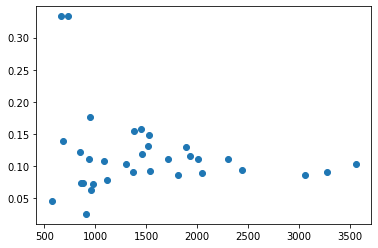

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x=join.PIB_per_cap, y=join.fracc_reincidencia)
join.iloc[:, 7:].corr().loc['PIB_per_cap']

In [ ]:
join.to_parquet('preprocessed_data/incidencia_dpto.parquet')